In [ ]:
!pip install micropip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,171 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126308 files and dire

In [ ]:
!ls -l '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

-rw-r--r-- 1 root root 4691820 May 14  2020 /usr/share/fonts/truetype/nanum/NanumGothic.ttf


In [ ]:
# 1. Matplotlib 캐시 디렉토리 찾아서 삭제 (필수)
# 이 코드를 실행하면 Matplotlib의 폰트 캐시 파일이 삭제됩니다.
!rm -rf ~/.cache/matplotlib
print("Matplotlib 폰트 캐시가 삭제되었습니다.")


Matplotlib 폰트 캐시가 삭제되었습니다.


In [ ]:

# 2. 런타임 재시작
# 이 셀을 실행한 후, Colab 상단 메뉴에서 '런타임' -> '런타임 다시 시작'을 클릭하거나,
# 키보드 단축키 (Ctrl+M)를 눌러 수동으로 런타임을 재시작해야 합니다.
# 이 코드 자체는 런타임을 강제 종료하는 것이므로,
# 메시지가 나오면 '세션 다시 시작' 버튼을 누르거나, 다시 시작 후 다음 셀로 넘어가세요.
import os
os.kill(os.getpid(), 9)

In [ ]:
# page16

import micropip
await micropip.install('seaborn')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.font_manager as fm

#fe = fm.FontEntry(fname='NotoSansKR-Regular.otf',name='NotoSansKR')
#fm.fontManager.ttflist.insert(0,fe)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#plt.rc('font',family='NotoSansKR')
#plt.style.use('fivethirtyeight')


font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# FontProperties 객체 생성
fontprop = fm.FontProperties(fname=font_path, size=10)

# Matplotlib의 폰트 설정 변경
plt.rc('font', family=fontprop.get_name()) # 폰트 설정
plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지

# 한글 폰트 설정 확인 (선택 사항)
print(f"현재 설정된 Matplotlib 폰트: {plt.rcParams['font.family']}")

현재 설정된 Matplotlib 폰트: ['NanumGothic']


In [ ]:
# 선형회귀 분석을 위한 테스트 데이터 가공용 => 아래단의 트레이이닝 데이터작업이 선행되야함 => 아파트 int 변환시 랭킹참조 및 le_arr 필요

import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


test = pd.read_csv('test.csv')

test['year'] = test['transaction_year_month'].astype(str).str[:4].astype(int)
test['month'] = test['transaction_year_month'].astype(str).str[4:].astype(int)

test.loc[(test['transaction_date'] == '21~30') | (test['transaction_date']=='21~28')| (test['transaction_date']=='21~29'), 'transaction_date'] = '21~31'

test.loc[(test['transaction_date'] == '1~10'), 'transaction_date'] = '01~10'
test['age'] = test['year'] - test['year_of_completion']

test.loc[test['age'] < 20, 'reconstruction'] = 'NO'
test.loc[test['age'] >= 20, 'reconstruction'] = 'YES'

regex = "\(.*\)"

for i in tqdm(range(len(test))):
  test.at[i,'apt'] = re.sub(regex, '', test.at[i,'apt'])

apt_brand_list = test['apt'].value_counts()[:20].index

test['branded'] = False

for brand in tqdm(apt_brand_list):
  #print(f"brand[{brand}]")
  if brand != '' :
    loc_list = test['apt'].str.contains(brand)

    test.loc[loc_list, 'apt'] = brand
    test.loc[loc_list, 'branded'] = True

test.loc[~test['branded'], 'apt'] = 'others'

# others=11
apt_dict = {"현대":'13', "삼성":'19', "동아":'15', "우성":'16', "한신":'5', "대림":'7', "두산":'14', "벽산":'1', "대우":'4', "극동":'6', "삼환":'2'}

for i in tqdm(range(len(test))):
  if test.at[i,'apt'] in apt_dict:
    test.at[i,'apt'] = apt_dict[test.at[i,'apt']]
  else:
    test.at[i,'apt'] = '11'

test.loc[:,'apt'] = test.loc[:,'apt'].astype('int')

test_X_cat = test[['city','transaction_date','reconstruction']]

le = le_arr['city']
test_X_cat.loc[:,'city'] = le.fit_transform(test_X_cat.loc[:,'city'])

le = le_arr['transaction_date']
test_X_cat.loc[:,'transaction_date'] = le.fit_transform(test_X_cat.loc[:,'transaction_date'])

le = le_arr['reconstruction']
test_X_cat.loc[:,'reconstruction'] = le.fit_transform(test_X_cat.loc[:,'reconstruction'])


test_X_num = test[['exclusive_use_area','floor','age']]
test_X_num.head()

test_minmax = mm_scaler.fit_transform(test_X_num)

test_minmax = pd.DataFrame(test_minmax, index=test_X_num.index, columns=test_X_num.columns)

X_test = pd.concat([test_minmax, test_X_cat, test['apt']], axis=1)
#y = test['transaction_real_price']

X_test.head()


100%|██████████| 5463/5463 [00:00<00:00, 30931.10it/s]


,exclusive_use_area,floor,age,city,transaction_date,reconstruction,apt
0,0.095730,0.053571,0.267857,1,1,0,11
1,0.221594,0.053571,0.714286,0,2,1,11
2,0.236089,0.053571,0.500000,0,1,1,11
3,0.384075,0.196429,0.232143,1,0,0,11
4,0.414810,0.392857,0.053571,0,1,0,11


In [ ]:
# 트레이닝 데이터 로드 및 가공 선작업

import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
train['year'] = train['transaction_year_month'].astype(str).str[:4].astype(int)
train['month'] = train['transaction_year_month'].astype(str).str[4:].astype(int)
train.loc[(train['transaction_date'] == '21~30') | (train['transaction_date']=='21~28')| (train['transaction_date']=='21~29'), 'transaction_date'] = '21~31'
train.loc[(train['transaction_date'] == '1~10'), 'transaction_date'] = '01~10'
train['price_per_area'] = train['transaction_real_price'] / train['exclusive_use_area']
train['price_per_pyoung'] = train['transaction_real_price'] / train['exclusive_use_area'] * 3.3
train['age'] = train['year'] - train['year_of_completion']
train.loc[train['age'] < 20, 'reconstruction'] = 'NO'
train.loc[train['age'] >= 20, 'reconstruction'] = 'YES'

from tqdm import tqdm
import time
import re

regex = "\(.*\)"

for i in tqdm(range(len(train))):
  train.at[i,'apt'] = re.sub(regex, '', train.at[i,'apt'])

apt_brand_list = train['apt'].value_counts()[:20].index

train['branded'] = False

for brand in tqdm(apt_brand_list):
  loc_list = train['apt'].str.contains(brand)

  train.loc[loc_list, 'apt'] = brand
  train.loc[loc_list, 'branded'] = True


train.loc[~train['branded'], 'apt'] = 'others'

apt_price = train.groupby('apt')['price_per_pyoung'].mean().sort_values(ascending=True)

for i, apt in enumerate(tqdm(apt_price.index)):
  train.loc[train['apt'] == apt, 'apt'] = i

train.loc[:,'apt'] = train.loc[:,'apt'].astype('int')

train['transaction_real_price'] = np.log1p(train['transaction_real_price'])

train = train.loc[train['price_per_pyoung']>=200,:]

train = train.drop(['transaction_id', 'apartment_id', 'dong', 'jibun', 'addr_kr'], axis=1)
train = train.drop(['transaction_year_month', 'year', 'month', 'year_of_completion', 'branded', 'price_per_pyoung'], axis=1)

train_X_cat = train[['city','transaction_date','reconstruction']]



from sklearn.preprocessing import LabelEncoder

le_arr = {}
le = LabelEncoder()
le_arr['city'] = le
train_X_cat.loc[:,'city'] = le.fit_transform(train_X_cat.loc[:,'city'])

le = LabelEncoder()
le_arr['transaction_date'] = le
train_X_cat.loc[:,'transaction_date'] = le.fit_transform(train_X_cat.loc[:,'transaction_date'])

le = LabelEncoder()
le_arr['reconstruction'] = le
train_X_cat.loc[:,'reconstruction'] = le.fit_transform(train_X_cat.loc[:,'reconstruction'])



train_X_num = train[['exclusive_use_area','floor','age']]

from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()

train_minmax = mm_scaler.fit_transform(train_X_num)

train_minmax = pd.DataFrame(train_minmax, index=train_X_num.index, columns=train_X_num.columns)

X = pd.concat([train_minmax, train_X_cat, train['apt']], axis=1)
y = train['transaction_real_price']

100%|██████████| 20/20 [00:01<00:00, 10.24it/s]


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1215874 entries, 0 to 1216552
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   exclusive_use_area  1215874 non-null  float64
 1   floor               1215874 non-null  float64
 2   age                 1215874 non-null  float64
 3   city                1215874 non-null  object 
 4   transaction_date    1215874 non-null  object 
 5   reconstruction      1215874 non-null  object 
 6   apt                 1215874 non-null  object 
dtypes: float64(3), object(4)
memory usage: 74.2+ MB


In [ ]:
# page125

from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# page5

from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

ad = AdaBoostRegressor(random_state=42)

def RMSE(y_real, y_pred):
  return mean_squared_error(y_real, y_pred)**0.5

model_ad = ad.fit(X_train, y_train)
ad_pred = model_ad.predict(X_test)

print("AdaBoostResgressor", RMSE(ad_pred, y_test))

AdaBoostResgressor 0.38332005087479737


In [ ]:
ad.feature_importances_

array([0.50863455, 0.04353316, 0.123841  , 0.27306905, 0.02775022,
       0.        , 0.02317202])

In [ ]:
# page7

ad_feature_importance = pd.DataFrame(ad.feature_importances_, X.columns, columns=['feature importance'])
ad_feature_importance = ad_feature_importance.sort_values('feature importance', ascending=False)
ad_feature_importance

,feature importance
exclusive_use_area,0.508635
city,0.273069
age,0.123841
floor,0.043533
transaction_date,0.027750
apt,0.023172
reconstruction,0.000000


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

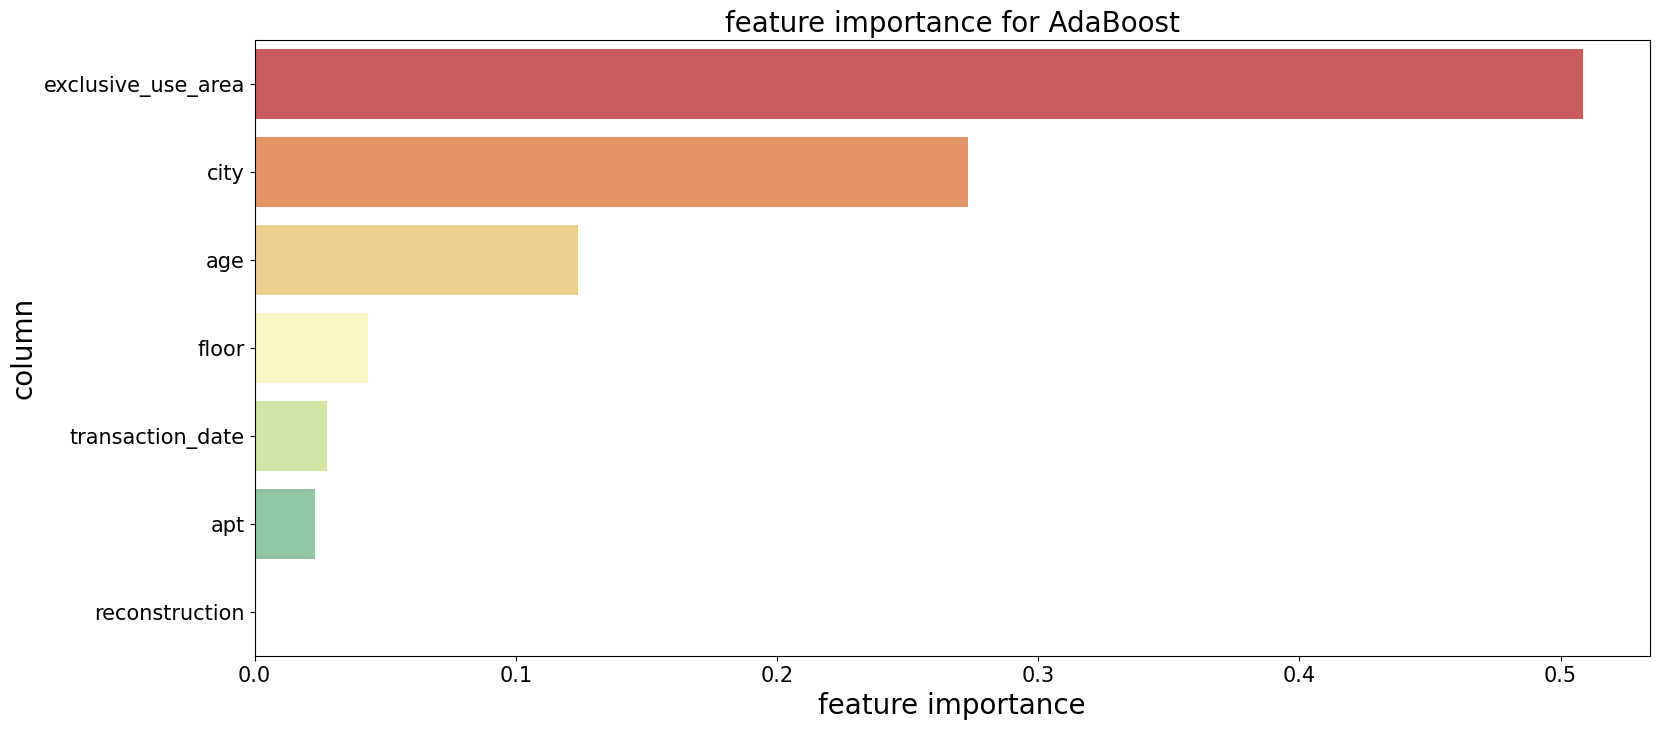

In [ ]:
# page8

plt.figure(figsize=(18,8))
sns.barplot(x='feature importance', y=ad_feature_importance.index, orient='h', data=ad_feature_importance, palette='Spectral')
plt.title('feature importance for AdaBoost', size=20)

plt.xticks(size=15)
plt.yticks(size=15)

plt.xlabel('feature importance', size=20)
plt.ylabel('column', size=20)
plt.show()

In [ ]:
# page13

from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(random_state=42, verbose=3)
model_gbm = gbm.fit(X_train, y_train)
gbm_pred = model_gbm.predict(X_test)

print('GBM=', RMSE(gbm_pred, y_test))

      Iter       Train Loss   Remaining Time 
         1           0.4306            1.38m
         2           0.3795            1.36m
         3           0.3379            1.34m
         4           0.3040            1.32m
         5           0.2763            1.30m
         6           0.2534            1.29m
         7           0.2346            1.28m
         8           0.2192            1.28m
         9           0.2064            1.26m
        10           0.1958            1.25m
        11           0.1867            1.23m
        12           0.1790            1.22m
        13           0.1728            1.21m
        14           0.1673            1.19m
        15           0.1627            1.18m
        16           0.1586            1.16m
        17           0.1551            1.15m
        18           0.1521            1.13m
        19           0.1496            1.12m
        20           0.1474            1.10m
        21           0.1454            1.09m
        2

In [ ]:
# page14

gbm_feature_importance = pd.DataFrame(gbm.feature_importances_, X.columns, columns=['feature importance'])
gbm_feature_importance = gbm_feature_importance.sort_values('feature importance', ascending=False)
gbm_feature_importance

,feature importance
city,0.465242
exclusive_use_area,0.462270
age,0.049876
floor,0.016859
apt,0.005754
transaction_date,0.000000
reconstruction,0.000000


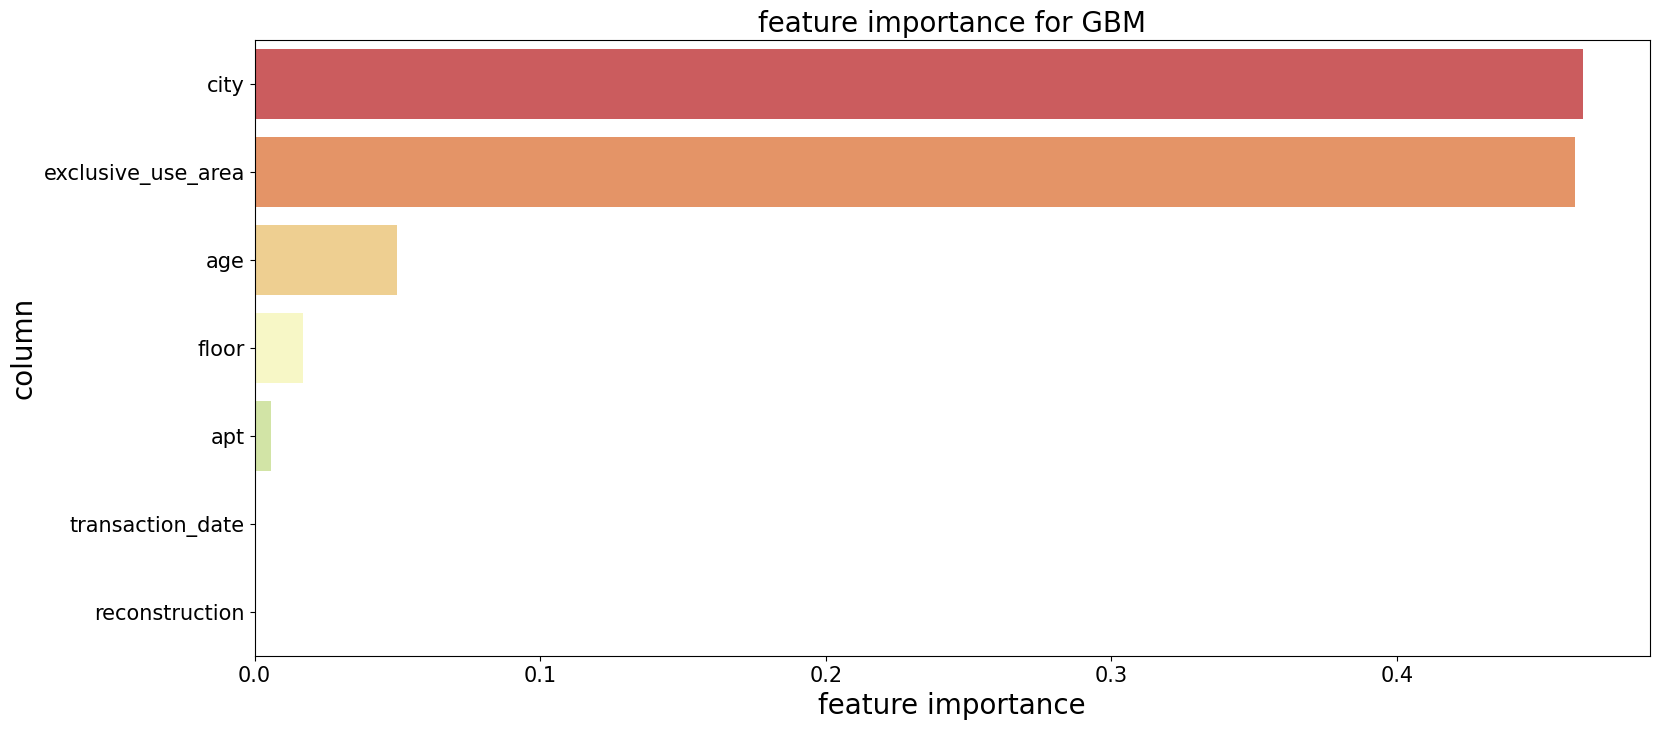

In [ ]:
# page15

plt.figure(figsize=(18,8))
sns.barplot(x='feature importance', y=gbm_feature_importance.index, orient='h', data=gbm_feature_importance, palette='Spectral')
plt.title('feature importance for GBM', size=20)

plt.xticks(size=15)
plt.yticks(size=15)

plt.xlabel('feature importance', size=20)
plt.ylabel('column', size=20)
plt.show()

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 972699 entries, 1204966 to 121967
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   exclusive_use_area  972699 non-null  float64
 1   floor               972699 non-null  float64
 2   age                 972699 non-null  float64
 3   city                972699 non-null  object 
 4   transaction_date    972699 non-null  object 
 5   reconstruction      972699 non-null  object 
 6   apt                 972699 non-null  object 
dtypes: float64(3), object(4)
memory usage: 59.4+ MB


In [ ]:
X_train = pd.concat([X_train['exclusive_use_area'], X_train['floor'], X_train['age'], X_train.loc[:,'apt'].astype('int64'), X_train.loc[:,'city'].astype('int64'), X_train.loc[:,'transaction_date'].astype('int64'), X_train.loc[:,'reconstruction'].astype('int64')], axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 972699 entries, 1204966 to 121967
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   exclusive_use_area  972699 non-null  float64
 1   floor               972699 non-null  float64
 2   age                 972699 non-null  float64
 3   apt                 972699 non-null  int64  
 4   city                972699 non-null  int64  
 5   transaction_date    972699 non-null  int64  
 6   reconstruction      972699 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 59.4 MB


In [ ]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 972699 entries, 1204966 to 121967
Series name: transaction_real_price
Non-Null Count   Dtype  
--------------   -----  
972699 non-null  float64
dtypes: float64(1)
memory usage: 14.8 MB


In [ ]:
# page18

from xgboost import XGBRegressor

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, verbose=3, eval_metric='rmse', early_stopping_rounds=50)

model_xgb = xgb.fit(X_tr, y_tr, eval_set=[(X_tr,y_tr),(X_val,y_val)])


[0]	validation_0-rmse:0.55431	validation_1-rmse:0.55402


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:23:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-rmse:0.46322	validation_1-rmse:0.46288
[2]	validation_0-rmse:0.40968	validation_1-rmse:0.40919
[3]	validation_0-rmse:0.37901	validation_1-rmse:0.37851
[4]	validation_0-rmse:0.36148	validation_1-rmse:0.36101
[5]	validation_0-rmse:0.35208	validation_1-rmse:0.35163
[6]	validation_0-rmse:0.34626	validation_1-rmse:0.34580
[7]	validation_0-rmse:0.34265	validation_1-rmse:0.34220
[8]	validation_0-rmse:0.34055	validation_1-rmse:0.34014
[9]	validation_0-rmse:0.33844	validation_1-rmse:0.33803
[10]	validation_0-rmse:0.33741	validation_1-rmse:0.33704
[11]	validation_0-rmse:0.33671	validation_1-rmse:0.33636
[12]	validation_0-rmse:0.33592	validation_1-rmse:0.33559
[13]	validation_0-rmse:0.33536	validation_1-rmse:0.33505
[14]	validation_0-rmse:0.33464	validation_1-rmse:0.33437
[15]	validation_0-rmse:0.33385	validation_1-rmse:0.33359
[16]	validation_0-rmse:0.33359	validation_1-rmse:0.33339
[17]	validation_0-rmse:0.33330	validation_1-rmse:0.33313
[18]	validation_0-rmse:0.33301	validatio

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243175 entries, 860142 to 1073411
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   exclusive_use_area  243175 non-null  float64
 1   floor               243175 non-null  float64
 2   age                 243175 non-null  float64
 3   city                243175 non-null  object 
 4   transaction_date    243175 non-null  object 
 5   reconstruction      243175 non-null  object 
 6   apt                 243175 non-null  object 
dtypes: float64(3), object(4)
memory usage: 14.8+ MB


In [ ]:
X_test = pd.concat([X_test['exclusive_use_area'], X_test['floor'], X_test['age'], X_test.loc[:,'apt'].astype('int64'), X_test.loc[:,'city'].astype('int64'), X_test.loc[:,'transaction_date'].astype('int64'), X_test.loc[:,'reconstruction'].astype('int64')], axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243175 entries, 860142 to 1073411
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   exclusive_use_area  243175 non-null  float64
 1   floor               243175 non-null  float64
 2   age                 243175 non-null  float64
 3   apt                 243175 non-null  int64  
 4   city                243175 non-null  int64  
 5   transaction_date    243175 non-null  int64  
 6   reconstruction      243175 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 14.8 MB


In [ ]:
# page 19
xgb_pred = model_xgb.predict(X_test)

print('XGB=', RMSE(xgb_pred, y_test))

XGB= 0.31985890610308687


In [ ]:
# page20

xgb_feature_importance = pd.DataFrame(xgb.feature_importances_, X.columns, columns=['feature importance'])
xgb_feature_importance = xgb_feature_importance.sort_values('feature importance', ascending=False)
xgb_feature_importance

,feature importance
transaction_date,0.783552
exclusive_use_area,0.158176
age,0.030607
floor,0.021574
city,0.004947
reconstruction,0.001145
apt,0.000000


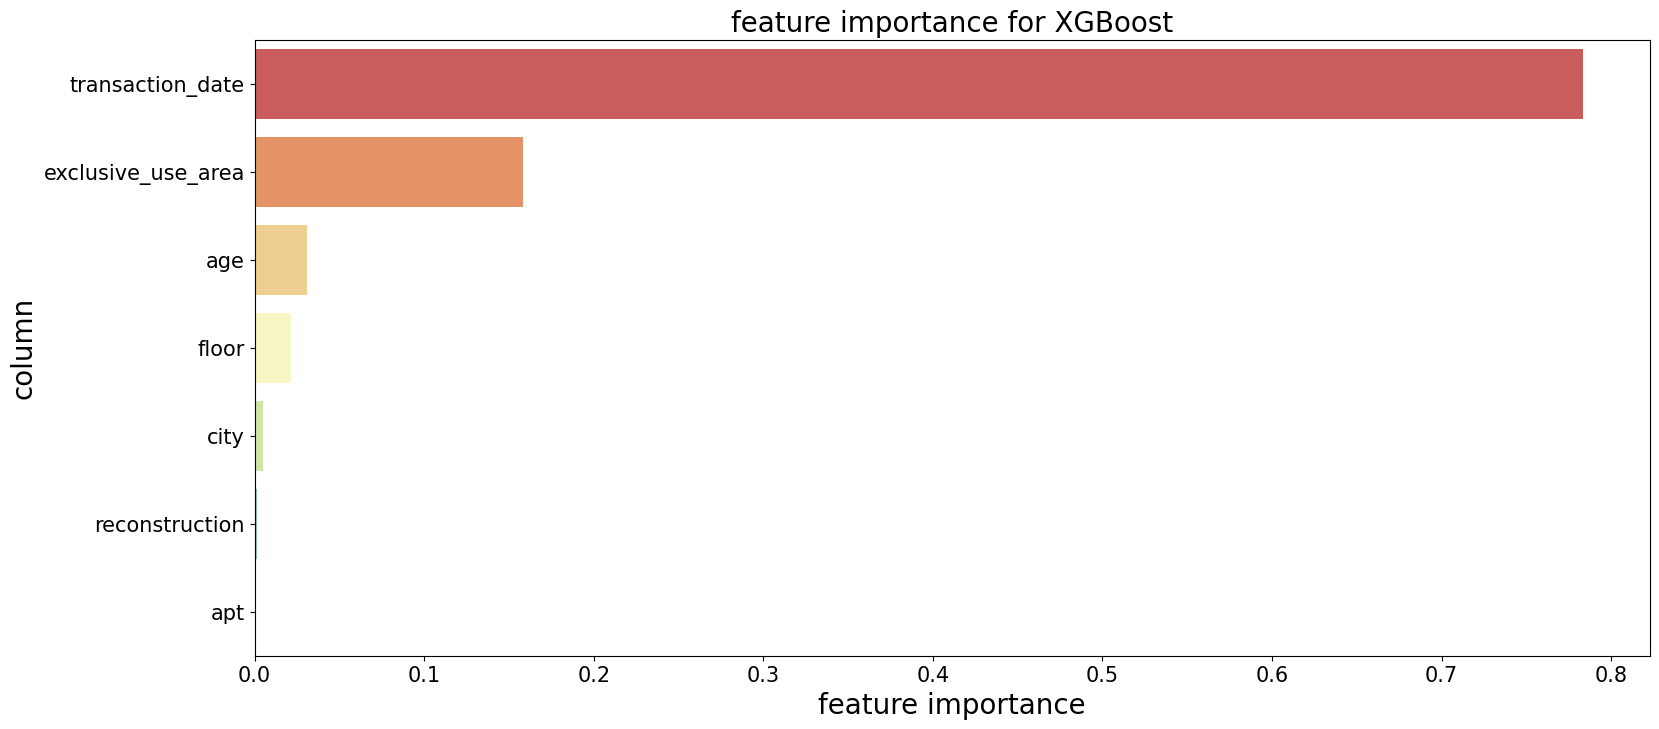

In [ ]:
# page22

plt.figure(figsize=(18,8))
sns.barplot(x='feature importance', y=xgb_feature_importance.index, orient='h', data=xgb_feature_importance, palette='Spectral')
plt.title('feature importance for XGBoost', size=20)

plt.xticks(size=15)
plt.yticks(size=15)

plt.xlabel('feature importance', size=20)
plt.ylabel('column', size=20)
plt.show()

In [ ]:
# page25

from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(random_state=42, verbose=3, eval_metric='rmse', early_stopping_rounds=50)

model_lbgm = lgbm.fit(X_tr, y_tr, eval_set=[(X_tr,y_tr),(X_val,y_val)])

lgbm_pred = model_lbgm.predict(X_test)

print('LGBM=', RMSE(lgbm_pred, y_test))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.205044
[LightGBM] [Debug] init for col-wise cost 0.000039 seconds, init for row-wise cost 0.008831 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 729524, number of used features: 7
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[L

In [ ]:
# page26

lgbm_feature_importance = pd.DataFrame(lgbm.feature_importances_, X.columns, columns=['feature importance'])
lgbm_feature_importance = lgbm_feature_importance.sort_values('feature importance', ascending=False)
lgbm_feature_importance

,feature importance
exclusive_use_area,1345
age,924
floor,369
transaction_date,183
city,166
reconstruction,13
apt,0


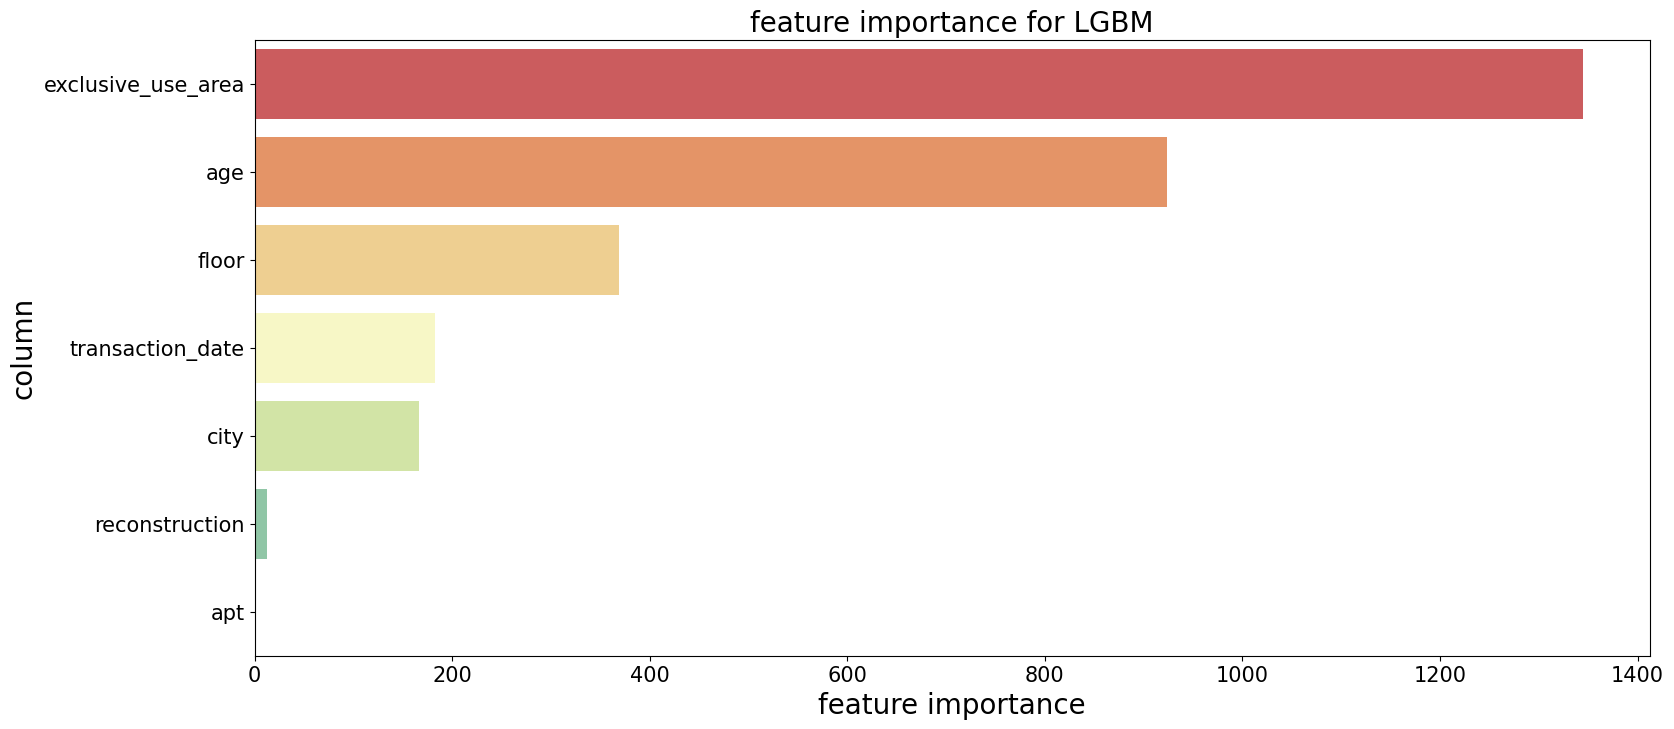

In [ ]:
# page28

plt.figure(figsize=(18,8))
sns.barplot(x='feature importance', y=lgbm_feature_importance.index, orient='h', data=lgbm_feature_importance, palette='Spectral')
plt.title('feature importance for LGBM', size=20)

plt.xticks(size=15)
plt.yticks(size=15)

plt.xlabel('feature importance', size=20)
plt.ylabel('column', size=20)
plt.show()

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 130.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/

In [ ]:
# page30

from pycaret.regression import *

In [ ]:
# page31

from pycaret.regression import *
full_train = pd.concat([X,y], axis=1)

categorical_features = ['city','transaction_date','reconstruction']
numeric_features = ['exclusive_use_area','floor','age','apt']

pyc_reg = setup(
    data=full_train,
    categorical_features=categorical_features,
    numeric_features=numeric_features,
    train_size=0.8,
    normalize=True,
    normalize_method='minmax',
    session_id=42
)

models = compare_models(fold=5, sort='RMSE', n_select=6, include=['rf','lr','gbr','ada','xgboost','lightgbm'])


,Description,Value
0,Session id,42
1,Target,transaction_real_price
2,Target type,Regression
3,Original data shape,"(1215874, 8)"
4,Transformed data shape,"(1215874, 10)"
5,Transformed train set shape,"(972699, 10)"
6,Transformed test set shape,"(243175, 10)"
7,Numeric features,4
8,Categorical features,3
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.1392,0.0474,0.2177,0.9040,0.0193,0.0136,45.9640
xgboost,Extreme Gradient Boosting,0.2338,0.0928,0.3047,0.8120,0.0270,0.0228,1.8060
lightgbm,Light Gradient Boosting Machine,0.2517,0.1042,0.3228,0.7889,0.0286,0.0245,132.1240
gbr,Gradient Boosting Regressor,0.2698,0.1182,0.3438,0.7605,0.0305,0.0263,17.7040
ada,AdaBoost Regressor,0.3014,0.1456,0.3816,0.7051,0.0338,0.0293,12.1680
lr,Linear Regression,0.3095,0.1534,0.3917,0.6891,0.0347,0.0301,1.3560


Processing:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
# page34~35

# 실습파일에 'gu' 정보가 없어서 'dong'정보로 처리해보겠습니다 => 확인결과에 따라 중복된 동이 4개 있으므로 예외 처리합니다.

# 트레이닝 데이터 로드 및 가공 선작업

import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
train['year'] = train['transaction_year_month'].astype(str).str[:4].astype(int)
train['month'] = train['transaction_year_month'].astype(str).str[4:].astype(int)
train.loc[(train['transaction_date'] == '21~30') | (train['transaction_date']=='21~28')| (train['transaction_date']=='21~29'), 'transaction_date'] = '21~31'
train.loc[(train['transaction_date'] == '1~10'), 'transaction_date'] = '01~10'
train['price_per_area'] = train['transaction_real_price'] / train['exclusive_use_area']
train['price_per_pyoung'] = train['transaction_real_price'] / train['exclusive_use_area'] * 3.3
train['age'] = train['year'] - train['year_of_completion']
train.loc[train['age'] < 20, 'reconstruction'] = 'NO'
train.loc[train['age'] >= 20, 'reconstruction'] = 'YES'

from tqdm import tqdm
import time
import re

regex = "\(.*\)"

for i in tqdm(range(len(train))):
  train.at[i,'apt'] = re.sub(regex, '', train.at[i,'apt'])

apt_brand_list = train['apt'].value_counts()[:20].index


brand_ranked = ['힐스테이트','푸르지오','자이','더샵','롯데캐슬','래미안','아이파크','e편한세상','위브','한화포레나','우미린','SK뷰',
                '호반베르디움','서희스타힐스','한라비발디','하늘채','더플래티넘','코아루','센트레빌','데시앙','스위첸','리슈빌','벽산블루밍',
                '동문굿모닝힐']

train['top_branded'] = 0
for brand in brand_ranked:
  train.loc[train['apt'].str.contains(brand), 'top_branded'] = 1

train['branded'] = False

for brand in tqdm(apt_brand_list):
  loc_list = train['apt'].str.contains(brand)

  train.loc[loc_list, 'apt'] = brand
  train.loc[loc_list, 'branded'] = True


train.loc[~train['branded'], 'apt'] = 'others'


#확인결과에 따라 중복된 동이 4개 있으므로 예외 처리합니다.
set_seoul_dong = set(train[train['city'] == '서울특별시']['dong'].unique())
set_busan_dong = set(train[train['city'] == '부산광역시']['dong'].unique())
intersec = set_seoul_dong.intersection(set_busan_dong)
print("intersect = ", set_seoul_dong.intersection(set_busan_dong))

for dong in tqdm(intersec):
  loc_list = train['dong'].str.contains(dong)

  train.loc[loc_list, 'dong'] = train.loc[loc_list]['city'] + dong

dong_price = train.groupby('dong')['price_per_area'].mean().sort_values(ascending=True)

for i,dong in enumerate(tqdm(dong_price.index)):
  train.loc[train['dong'] == dong, 'dong'] = i


apt_price = train.groupby('apt')['price_per_pyoung'].mean().sort_values(ascending=True)

for i, apt in enumerate(tqdm(apt_price.index)):
  train.loc[train['apt'] == apt, 'apt'] = i

train.loc[:,'apt'] = train.loc[:,'apt'].astype('int')

train['transaction_real_price'] = np.log1p(train['transaction_real_price'])

train = train.loc[train['price_per_pyoung']>=200,:]

train = train.drop(['transaction_id', 'apartment_id', 'jibun', 'addr_kr'], axis=1)
train = train.drop(['transaction_year_month', 'year', 'month', 'year_of_completion', 'branded', 'price_per_pyoung'], axis=1)

train_X_cat = train[['city','transaction_date','reconstruction']]



from sklearn.preprocessing import LabelEncoder

le_arr = {}
le = LabelEncoder()
le_arr['city'] = le
train_X_cat.loc[:,'city'] = le.fit_transform(train_X_cat.loc[:,'city'])

le = LabelEncoder()
le_arr['transaction_date'] = le
train_X_cat.loc[:,'transaction_date'] = le.fit_transform(train_X_cat.loc[:,'transaction_date'])

le = LabelEncoder()
le_arr['reconstruction'] = le
train_X_cat.loc[:,'reconstruction'] = le.fit_transform(train_X_cat.loc[:,'reconstruction'])



train_X_num = train[['exclusive_use_area','floor','age']]

from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()

train_minmax = mm_scaler.fit_transform(train_X_num)

train_minmax = pd.DataFrame(train_minmax, index=train_X_num.index, columns=train_X_num.columns)

X = pd.concat([train_minmax, train_X_cat, train['apt'], train['dong'], train['top_branded']], axis=1)
y = train['transaction_real_price']

100%|██████████| 20/20 [00:08<00:00,  2.50it/s]


intersect =  {'중동', '사직동', '송정동', '부암동'}


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


In [ ]:
X = pd.concat([X['exclusive_use_area'], X['floor'], X['age'], X['top_branded'], X.loc[:,'apt'].astype('int64'), X.loc[:,'city'].astype('int64'), X.loc[:,'transaction_date'].astype('int64'), X.loc[:,'reconstruction'].astype('int64'), X.loc[:,'dong'].astype('int64')], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1215874 entries, 0 to 1216552
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   exclusive_use_area  1215874 non-null  float64
 1   floor               1215874 non-null  float64
 2   age                 1215874 non-null  float64
 3   top_branded         1215874 non-null  int64  
 4   apt                 1215874 non-null  int64  
 5   city                1215874 non-null  int64  
 6   transaction_date    1215874 non-null  int64  
 7   reconstruction      1215874 non-null  int64  
 8   dong                1215874 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 92.8 MB


In [ ]:
from sklearn.model_selection import train_test_split

# 성능평가용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 부스팅모델 검증용
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)


In [ ]:
# page36
from sklearn.metrics import mean_squared_error

def RMSE(y_real, y_pred):
  return mean_squared_error(y_real, y_pred)**0.5


from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', verbose=0, random_state=42, eval_metric='rmse', early_stopping_rounds=50)
model_xgb = xgb.fit(X_tr, y_tr, eval_set=[(X_tr,y_tr),(X_val,y_val)])
xgb_pred = model_xgb.predict(X_test)
print('XGBoost=', RMSE(xgb_pred, y_test))


from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(random_state=42, eval_metric='rmse', early_stopping_rounds=50, verbose=0)
model_lbgm = lgbm.fit(X_tr, y_tr, eval_set=[(X_tr,y_tr),(X_val,y_val)])
lgbm_pred = model_lbgm.predict(X_test)
print('LightGBM=', RMSE(lgbm_pred, y_test))



[0]	validation_0-rmse:0.53074	validation_1-rmse:0.53142
[1]	validation_0-rmse:0.41914	validation_1-rmse:0.41969
[2]	validation_0-rmse:0.34946	validation_1-rmse:0.34987
[3]	validation_0-rmse:0.30706	validation_1-rmse:0.30738
[4]	validation_0-rmse:0.28147	validation_1-rmse:0.28179
[5]	validation_0-rmse:0.26658	validation_1-rmse:0.26691
[6]	validation_0-rmse:0.25695	validation_1-rmse:0.25733
[7]	validation_0-rmse:0.25123	validation_1-rmse:0.25160
[8]	validation_0-rmse:0.24733	validation_1-rmse:0.24774
[9]	validation_0-rmse:0.24453	validation_1-rmse:0.24497
[10]	validation_0-rmse:0.24230	validation_1-rmse:0.24276
[11]	validation_0-rmse:0.24030	validation_1-rmse:0.24079
[12]	validation_0-rmse:0.23930	validation_1-rmse:0.23984
[13]	validation_0-rmse:0.23822	validation_1-rmse:0.23878
[14]	validation_0-rmse:0.23756	validation_1-rmse:0.23820
[15]	validation_0-rmse:0.23680	validation_1-rmse:0.23745
[16]	validation_0-rmse:0.23631	validation_1-rmse:0.23698
[17]	validation_0-rmse:0.23578	validation

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, verbose=0)
model_rf = rf.fit(X_train, y_train)
rf_pred = model_rf.predict(X_test)
print('RandomForest=', RMSE(rf_pred, y_test))


RandomForest= 0.1079149860365204


In [ ]:
print('XGBoost=', RMSE(xgb_pred, y_test))
print('LightGBM=', RMSE(lgbm_pred, y_test))
print('RandomForest=', RMSE(rf_pred, y_test))

XGBoost= 0.2023060048286173
LightGBM= 0.22731662492212726
RandomForest= 0.1079149860365204


In [ ]:
# page37

import time

start = time.time()
model_rf = rf.fit(X_tr, y_tr)
end = time.time()

rf_time = end - start

rf_test_pred = model_rf.predict(X_test)

print("RMSE:",RMSE(rf_test_pred, y_test),RMSE(y_test, rf_test_pred), "RF time:",rf_time,"sec")


RMSE: 0.12045996120649408 0.12045996120649408 RF time: 175.52374005317688 sec


In [ ]:
# page38

from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(objective='regression', random_state=42, eval_metric='rmse', early_stopping_rounds=50)

start = time.time()
model_lbgm = lgbm.fit(X_tr, y_tr, eval_set=[(X_tr,y_tr),(X_val,y_val)])

end = time.time()

lgbm_time = end - start

lgbm_test_pred = model_lbgm.predict(X_test)

print("RMSE:",RMSE(y_test, lgbm_test_pred), "LGBM time:",lgbm_time,"sec")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.0514533	valid_1's l2: 0.0517667
[LightGBM] [Warning] Unknown parameter: eval_metric
RMSE: 0.22731662492212726 LGBM time: 1.3569376468658447 sec


In [ ]:
# page40

from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=50)

start = time.time()
model_xgb = xgb.fit(X_tr, y_tr, eval_set=[(X_tr,y_tr),(X_val,y_val)])

end = time.time()

xgb_time = end - start

xgb_test_pred = model_xgb.predict(X_test)

print("RMSE:",RMSE(y_test, xgb_test_pred), "XGB time:",xgb_time,"sec")


[0]	validation_0-rmse:0.53074	validation_1-rmse:0.53142
[1]	validation_0-rmse:0.41914	validation_1-rmse:0.41969
[2]	validation_0-rmse:0.34946	validation_1-rmse:0.34987
[3]	validation_0-rmse:0.30706	validation_1-rmse:0.30738
[4]	validation_0-rmse:0.28147	validation_1-rmse:0.28179
[5]	validation_0-rmse:0.26658	validation_1-rmse:0.26691
[6]	validation_0-rmse:0.25695	validation_1-rmse:0.25733
[7]	validation_0-rmse:0.25123	validation_1-rmse:0.25160
[8]	validation_0-rmse:0.24733	validation_1-rmse:0.24774
[9]	validation_0-rmse:0.24453	validation_1-rmse:0.24497
[10]	validation_0-rmse:0.24230	validation_1-rmse:0.24276
[11]	validation_0-rmse:0.24030	validation_1-rmse:0.24079
[12]	validation_0-rmse:0.23930	validation_1-rmse:0.23984
[13]	validation_0-rmse:0.23822	validation_1-rmse:0.23878
[14]	validation_0-rmse:0.23756	validation_1-rmse:0.23820
[15]	validation_0-rmse:0.23680	validation_1-rmse:0.23745
[16]	validation_0-rmse:0.23631	validation_1-rmse:0.23698
[17]	validation_0-rmse:0.23578	validation

In [1]:
# page43

import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
train['year'] = train['transaction_year_month'].astype(str).str[:4].astype(int)
train['month'] = train['transaction_year_month'].astype(str).str[4:].astype(int)
train.loc[(train['transaction_date'] == '21~30') | (train['transaction_date']=='21~28')| (train['transaction_date']=='21~29'), 'transaction_date'] = '21~31'
train.loc[(train['transaction_date'] == '1~10'), 'transaction_date'] = '01~10'
train['price_per_area'] = train['transaction_real_price'] / train['exclusive_use_area']
train['price_per_pyoung'] = train['transaction_real_price'] / train['exclusive_use_area'] * 3.3
train['age'] = train['year'] - train['year_of_completion']
train.loc[train['age'] < 20, 'reconstruction'] = 'NO'
train.loc[train['age'] >= 20, 'reconstruction'] = 'YES'


print("year :\n", train.groupby('year').size())
print()
print("year,price_per_area :\n", train.groupby('year')['price_per_area'].mean())


from tqdm import tqdm
import time
import re

regex = "\(.*\)"

for i in tqdm(range(len(train))):
  train.at[i,'apt'] = re.sub(regex, '', train.at[i,'apt'])

apt_brand_list = train['apt'].value_counts()[:20].index


brand_ranked = ['힐스테이트','푸르지오','자이','더샵','롯데캐슬','래미안','아이파크','e편한세상','위브','한화포레나','우미린','SK뷰',
                '호반베르디움','서희스타힐스','한라비발디','하늘채','더플래티넘','코아루','센트레빌','데시앙','스위첸','리슈빌','벽산블루밍',
                '동문굿모닝힐']

train['top_branded'] = 0
for brand in brand_ranked:
  train.loc[train['apt'].str.contains(brand), 'top_branded'] = 1

train['branded'] = False

for brand in tqdm(apt_brand_list):
  loc_list = train['apt'].str.contains(brand)

  train.loc[loc_list, 'apt'] = brand
  train.loc[loc_list, 'branded'] = True


train.loc[~train['branded'], 'apt'] = 'others'


#확인결과에 따라 중복된 동이 4개 있으므로 예외 처리합니다.
set_seoul_dong = set(train[train['city'] == '서울특별시']['dong'].unique())
set_busan_dong = set(train[train['city'] == '부산광역시']['dong'].unique())
intersec = set_seoul_dong.intersection(set_busan_dong)
print("intersect = ", set_seoul_dong.intersection(set_busan_dong))

for dong in tqdm(intersec):
  loc_list = train['dong'].str.contains(dong)

  train.loc[loc_list, 'dong'] = train.loc[loc_list]['city'] + dong

dong_price = train.groupby('dong')['price_per_area'].mean().sort_values(ascending=True)

for i,dong in enumerate(tqdm(dong_price.index)):
  train.loc[train['dong'] == dong, 'dong'] = i


apt_price = train.groupby('apt')['price_per_pyoung'].mean().sort_values(ascending=True)

for i, apt in enumerate(tqdm(apt_price.index)):
  train.loc[train['apt'] == apt, 'apt'] = i

train.loc[:,'apt'] = train.loc[:,'apt'].astype('int')

train['transaction_real_price'] = np.log1p(train['transaction_real_price'])

#2014년 이후의 데이터만 처리함
train = train.loc[train['year']>=2014,:]
train = train.loc[train['price_per_pyoung']>=200,:]

train = train.drop(['transaction_id', 'apartment_id', 'jibun', 'addr_kr'], axis=1)
train = train.drop(['transaction_year_month', 'year', 'month', 'year_of_completion', 'branded', 'price_per_pyoung'], axis=1)

train_X_cat = train[['city','transaction_date','reconstruction']]



from sklearn.preprocessing import LabelEncoder

le_arr = {}
le = LabelEncoder()
le_arr['city'] = le
train_X_cat.loc[:,'city'] = le.fit_transform(train_X_cat.loc[:,'city'])

le = LabelEncoder()
le_arr['transaction_date'] = le
train_X_cat.loc[:,'transaction_date'] = le.fit_transform(train_X_cat.loc[:,'transaction_date'])

le = LabelEncoder()
le_arr['reconstruction'] = le
train_X_cat.loc[:,'reconstruction'] = le.fit_transform(train_X_cat.loc[:,'reconstruction'])



train_X_num = train[['exclusive_use_area','floor','age']]

from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()

train_minmax = mm_scaler.fit_transform(train_X_num)

train_minmax = pd.DataFrame(train_minmax, index=train_X_num.index, columns=train_X_num.columns)

X = pd.concat([train_minmax, train_X_cat, train['apt'], train['dong'], train['top_branded']], axis=1)
y = train['transaction_real_price']

year :
 year
2008    100066
2009    127869
2010    102823
2011     98586
2012     70065
2013    109738
2014    136649
2015    181195
2016    165664
2017    123898
dtype: int64

year,price_per_area :
 year
2008    371.986343
2009    443.344932
2010    387.150633
2011    438.326002
2012    443.270052
2013    449.025207
2014    466.183631
2015    505.157006
2016    559.931274
2017    661.357186
Name: price_per_area, dtype: float64


100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


intersect =  {'부암동', '송정동', '사직동', '중동'}


100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


In [2]:
X = pd.concat([X['exclusive_use_area'], X['floor'], X['age'], X['top_branded'], X.loc[:,'apt'].astype('int64'), X.loc[:,'city'].astype('int64'), X.loc[:,'transaction_date'].astype('int64'), X.loc[:,'reconstruction'].astype('int64'), X.loc[:,'dong'].astype('int64')], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607254 entries, 2700 to 1216552
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   exclusive_use_area  607254 non-null  float64
 1   floor               607254 non-null  float64
 2   age                 607254 non-null  float64
 3   top_branded         607254 non-null  int64  
 4   apt                 607254 non-null  int64  
 5   city                607254 non-null  int64  
 6   transaction_date    607254 non-null  int64  
 7   reconstruction      607254 non-null  int64  
 8   dong                607254 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 46.3 MB


In [3]:
# page44

from sklearn.model_selection import train_test_split

# 성능평가용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 부스팅모델 검증용
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
# page45

start = time.time()
model_rf = rf.fit(X_tr, y_tr)
end = time.time()

rf_time = end - start

rf_test_pred = model_rf.predict(X_test)

print("RMSE:",RMSE(y_test, rf_test_pred), "RF time:",rf_time,"sec")

RMSE: 0.0933896269298493 RF time: 125.16172313690186 sec


In [ ]:
# page46

start = time.time()
model_lbgm = lgbm.fit(X_tr, y_tr, eval_set=[(X_tr,y_tr),(X_val,y_val)])

end = time.time()

lgbm_time = end - start

lgbm_test_pred = model_lbgm.predict(X_test)

print("RMSE:",RMSE(y_test, lgbm_test_pred), "LGBM time:",lgbm_time,"sec")

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.0312972	valid_1's l2: 0.0313754
[LightGBM] [Warning] Unknown parameter: eval_metric
RMSE: 0.17823195832574132 LGBM time: 0.7933452129364014 sec


In [ ]:
# page47

start = time.time()
model_xgb = xgb.fit(X_tr, y_tr, eval_set=[(X_tr,y_tr),(X_val,y_val)])

end = time.time()

xgb_time = end - start

xgb_test_pred = model_xgb.predict(X_test)

print("RMSE:",RMSE(y_test, xgb_test_pred), "XGB time:",xgb_time,"sec")

[0]	validation_0-rmse:0.47927	validation_1-rmse:0.47882
[1]	validation_0-rmse:0.37267	validation_1-rmse:0.37220
[2]	validation_0-rmse:0.30427	validation_1-rmse:0.30374
[3]	validation_0-rmse:0.26122	validation_1-rmse:0.26080
[4]	validation_0-rmse:0.23554	validation_1-rmse:0.23504
[5]	validation_0-rmse:0.21875	validation_1-rmse:0.21841
[6]	validation_0-rmse:0.20915	validation_1-rmse:0.20881
[7]	validation_0-rmse:0.20268	validation_1-rmse:0.20238
[8]	validation_0-rmse:0.19828	validation_1-rmse:0.19812
[9]	validation_0-rmse:0.19491	validation_1-rmse:0.19485
[10]	validation_0-rmse:0.19222	validation_1-rmse:0.19228
[11]	validation_0-rmse:0.19063	validation_1-rmse:0.19067
[12]	validation_0-rmse:0.18874	validation_1-rmse:0.18889
[13]	validation_0-rmse:0.18792	validation_1-rmse:0.18811
[14]	validation_0-rmse:0.18711	validation_1-rmse:0.18738
[15]	validation_0-rmse:0.18629	validation_1-rmse:0.18663
[16]	validation_0-rmse:0.18587	validation_1-rmse:0.18628
[17]	validation_0-rmse:0.18506	validation

In [ ]:
# page49

from sklearn.model_selection import GridSearchCV

rf_params_grid = {
    'n_estimators':[100,150,200,250],
    'max_depth':[10,20,25],
    'max_features':[0.33,1],
    'n_jobs':[-1]
}

rf_grid_cv = GridSearchCV(rf, param_grid=rf_params_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=3)
rf_grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END max_depth=10, max_features=0.33, n_estimators=100, n_jobs=-1;, score=-0.203 total time=   2.4s
[CV 2/3] END max_depth=10, max_features=0.33, n_estimators=100, n_jobs=-1;, score=-0.203 total time=   2.4s
[CV 3/3] END max_depth=10, max_features=0.33, n_estimators=100, n_jobs=-1;, score=-0.204 total time=   2.4s
[CV 1/3] END max_depth=10, max_features=0.33, n_estimators=150, n_jobs=-1;, score=-0.202 total time=   3.7s
[CV 2/3] END max_depth=10, max_features=0.33, n_estimators=150, n_jobs=-1;, score=-0.202 total time=   3.5s
[CV 3/3] END max_depth=10, max_features=0.33, n_estimators=150, n_jobs=-1;, score=-0.203 total time=   3.5s
[CV 1/3] END max_depth=10, max_features=0.33, n_estimators=200, n_jobs=-1;, score=-0.201 total time=   4.7s
[CV 2/3] END max_depth=10, max_features=0.33, n_estimators=200, n_jobs=-1;, score=-0.202 total time=   4.7s
[CV 3/3] END max_depth=10, max_features=0.33, n_estimators=200, n_jobs=-1;,

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 25], 'max_features': [0.33, 1],
                         'n_estimators': [100, 150, 200, 250], 'n_jobs': [-1]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
# page49

print("Best Score:", rf_grid_cv.best_score_)
print("Best Parameters:", rf_grid_cv.best_params_)
print("Best Estimator:", rf_grid_cv.best_estimator_)

rf_cv_pred = rf_grid_cv.predict(X_test)
print("RMSE:",RMSE(y_test, rf_cv_pred))

Best Score: -0.11809394103431364
Best Parameters: {'max_depth': 25, 'max_features': 0.33, 'n_estimators': 250, 'n_jobs': -1}
Best Estimator: RandomForestRegressor(max_depth=25, max_features=0.33, n_estimators=250,
                      n_jobs=-1, random_state=42)
RMSE: 0.11164464140717384


In [ ]:
# page50

from sklearn.model_selection import GridSearchCV

lgbm_params_grid = {
    'subsample':[0.5,0.7,0.9],
    'learning_rate':[0.1,0.3,0.7],
    'n_estimators':[3000,5000,9000],
    'max_depth':[5,8,13],
    'colsample_bytree':[0.7,0.8]
}

lgbm = LGBMRegressor(objective='regression', random_state=42)

lgbm_grid_cv = GridSearchCV(lgbm, param_grid=lgbm_params_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=0)
lgbm_grid_cv.fit(X_train, y_train)

[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=9000, subsample=0.9;, score=-0.100 total time=  42.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=9000, subsample=0.9;, score=-0.101 total time=  42.0s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=13, n_estimators=3000, subsample=0.5;, score=-0.102 total time=  14.6s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=13, n_estimators=3000, subsample=0.5;, score=-0.102 total time=  14.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=13, n_estimators=3000, subsample=0.5;, score=-0.103 total time=  14.0s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=13, n_estimators=3000, subsample=0.7;, score=-0.102 total time=  14.0s
[CV 2/3] END colsample_bytree=0.8, learnin

GridSearchCV(cv=3,
             estimator=LGBMRegressor(objective='regression', random_state=42),
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'learning_rate': [0.1, 0.3, 0.7],
                         'max_depth': [5, 8, 13],
                         'n_estimators': [3000, 5000, 9000],
                         'subsample': [0.5, 0.7, 0.9]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
# page49

print("Best Score:", lgbm_grid_cv.best_score_)
print("Best Parameters:", lgbm_grid_cv.best_params_)
print("Best Estimator:", lgbm_grid_cv.best_estimator_)

lgbm_cv_pred = lgbm_grid_cv.predict(X_test)
print("RMSE:",RMSE(y_test, lgbm_cv_pred))

Best Score: -0.09609843970697751
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 9000, 'subsample': 0.5}
Best Estimator: LGBMRegressor(colsample_bytree=0.8, learning_rate=0.3, max_depth=8,
              n_estimators=9000, objective='regression', random_state=42,
              subsample=0.5)
RMSE: 0.0913298809516919


In [ ]:
# page50

from sklearn.model_selection import GridSearchCV

xgb_params_grid = {
    'subsample':[0.7,0.8,0.9],
    'learning_rate':[0.1,0.3,0.7],
    'n_estimators':[300,600,000],
    'max_depth':[5,8],
    'colsample_bytree':[0.8,0.9]
}

xgb_grid_cv = GridSearchCV(xgb, param_grid=xgb_params_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=3)
xgb_grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytr

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=50,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.1, 0.3, 0.7], 'max_depth': [5, 8],
                         'n_estimators': [300, 600, 0],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
print("Best Score:", xgb_grid_cv.best_score_)
print("Best Parameters:", xgb_grid_cv.best_params_)
print("Best Estimator:", xgb_grid_cv.best_estimator_)

xgb_cv_pred = xgb_grid_cv.predict(X_test)
print("RMSE:",RMSE(y_test, xgb_cv_pred))

Best Score: -9.982982935347797
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 0, 'subsample': 0.7}
Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=0, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
RMSE: 9.98035033261725


In [7]:
# 20250705 재실행 결과
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

def RMSE(y_real, y_pred):
  return mean_squared_error(y_real, y_pred)**0.5

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, verbose=-1, eval_metric='rmse', early_stopping_rounds=50)

start = time.time()
model_xgb = xgb.fit(X_tr, y_tr, eval_set=[(X_tr,y_tr),(X_val,y_val)])

end = time.time()

xgb_time = end - start

xgb_test_pred = model_xgb.predict(X_test)

print("RMSE:",RMSE(y_test, xgb_test_pred), "XGB time:",xgb_time,"sec")

[0]	validation_0-rmse:0.47927	validation_1-rmse:0.47882
[1]	validation_0-rmse:0.37267	validation_1-rmse:0.37220
[2]	validation_0-rmse:0.30427	validation_1-rmse:0.30374
[3]	validation_0-rmse:0.26122	validation_1-rmse:0.26080


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-rmse:0.23554	validation_1-rmse:0.23504
[5]	validation_0-rmse:0.21875	validation_1-rmse:0.21841
[6]	validation_0-rmse:0.20915	validation_1-rmse:0.20881
[7]	validation_0-rmse:0.20268	validation_1-rmse:0.20238
[8]	validation_0-rmse:0.19828	validation_1-rmse:0.19812
[9]	validation_0-rmse:0.19491	validation_1-rmse:0.19485
[10]	validation_0-rmse:0.19222	validation_1-rmse:0.19228
[11]	validation_0-rmse:0.19063	validation_1-rmse:0.19067
[12]	validation_0-rmse:0.18874	validation_1-rmse:0.18889
[13]	validation_0-rmse:0.18792	validation_1-rmse:0.18811
[14]	validation_0-rmse:0.18711	validation_1-rmse:0.18738
[15]	validation_0-rmse:0.18629	validation_1-rmse:0.18663
[16]	validation_0-rmse:0.18587	validation_1-rmse:0.18628
[17]	validation_0-rmse:0.18506	validation_1-rmse:0.18549
[18]	validation_0-rmse:0.18419	validation_1-rmse:0.18469
[19]	validation_0-rmse:0.18364	validation_1-rmse:0.18419
[20]	validation_0-rmse:0.18320	validation_1-rmse:0.18379
[21]	validation_0-rmse:0.18279	valida

In [8]:


from sklearn.model_selection import GridSearchCV

xgb_params_grid = {
    'subsample':[0.7,0.8,0.9],
    'learning_rate':[0.1,0.3,0.7],
    'n_estimators':[300,600,000],
    'max_depth':[5,8],
    'colsample_bytree':[0.8,0.9]
}

xgb_grid_cv = GridSearchCV(xgb, param_grid=xgb_params_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=3)
xgb_grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.3s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.3s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.1s
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.8, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.5s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.1s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.3, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.7;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=600, subsample=0.9;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.2s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.3s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=5, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.7;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.8;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=300, subsample=0.9;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.7;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.2s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.8;, score=nan total time=   0.1s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=600, subsample=0.9;, score=nan total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.7;, score=-9.985 total time=   0.2s
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.983 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.981 total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.8;, score=-9.985 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.983 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.981 total time=   0.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:58:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
216 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.7, max_depth=8, n_estimators=0, subsample=0.9;, score=-9.985 total time=   0.1s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=50,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.1, 0.3, 0.7], 'max_depth': [5, 8],
                         'n_estimators': [300, 600, 0],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [9]:
print("Best Score:", xgb_grid_cv.best_score_)
print("Best Parameters:", xgb_grid_cv.best_params_)
print("Best Estimator:", xgb_grid_cv.best_estimator_)

xgb_cv_pred = xgb_grid_cv.predict(X_test)
print("RMSE:",RMSE(y_test, xgb_cv_pred))

Best Score: -9.982982935347797
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 0, 'subsample': 0.7}
Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=0, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
RMSE: 9.980350332617252
